# Netcdf4 file 예제
- netcdf는 grib에 비해 보다 간단한 형식이지만 압축률은 낮음
- using ERA5 dataset (ECMWF ReAnalysis 5)
- 재분석자료는 과거, 현재, 미래의 정보를 모두 활용하여 그 시각의 분석장을 나타낸 것
- 수치모델 분석장보다 더 정확하고, 격자 자료 중 얻을 수 있는 최선으로 간주됨
- 그러나 미래 정보를 요구하므로 자료 생산에 지연이 생김 (ERA5는 일주일 정도)

# downloading
- ERA5 자료를 내려받는 API
- CDS 계정을 생성하고 키를 파이썬 경로(보통 C:\사용자\username)에 저장 (메모장에서 저장할 때 모든 파일로 .cdsapirc라 저장)
- anaconda prompt에서 conda install -c conda-forge cdsapi 실행
- https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels%3Ftab=form?tab=form
- https://confluence.ecmwf.int/display/CKB/How+to+install+and+use+CDS+API+on+Windows
- https://cds.climate.copernicus.eu/api-how-to
- https://confluence.ecmwf.int/display/CKB/How+to+download+ERA5


In [3]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            '2m_temperature', 'mean_sea_level_pressure',
        ],
        'year': '2020',
        'month': '10',
        'day': '06',
        'time': '00:00',
        'grid': [1.0, 1.0],
    },
    'era5_sfc_2020100600.nc')

2020-10-14 16:49:45,309 INFO Welcome to the CDS
2020-10-14 16:49:45,312 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2020-10-14 16:49:47,992 INFO Request is queued
2020-10-14 16:49:51,071 INFO Request is completed
2020-10-14 16:49:51,071 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data9/adaptor.mars.internal-1602661789.635684-27686-32-28cc34d3-beec-4fa5-9d2a-ff01588af10c.nc to era5_sfc_2020100600.nc (258K)
2020-10-14 16:49:54,059 INFO Download rate 86.4K/s                                                                     


Result(content_length=264176,content_type=application/x-netcdf,location=http://136.156.133.32/cache-compute-0009/cache/data9/adaptor.mars.internal-1602661789.635684-27686-32-28cc34d3-beec-4fa5-9d2a-ff01588af10c.nc)

In [4]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': 
        ['temperature', 'geopotential', 'u_component_of_wind', 'v_component_of_wind'],
        'pressure_level': 
        ['200', '300', '500','700', '850', '925','1000'],
        'year': '2020',
        'month': '10',
        'day': '06',
        'time': '00:00',
        'grid': [1.0, 1.0],
    },
    'era5_pres_2020100600.nc')

2020-10-14 15:42:41,026 INFO Welcome to the CDS
2020-10-14 15:42:41,028 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-10-14 15:42:42,265 INFO Request is queued
2020-10-14 15:42:43,554 INFO Request is running
2020-10-14 15:42:45,344 INFO Request is completed
2020-10-14 15:42:45,344 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data1/adaptor.mars.internal-1602657762.182757-8856-25-86d5fbbc-39a9-4637-b2b5-94e772a9db22.nc to download.nc (3.5M)
2020-10-14 15:42:58,679 INFO Download rate 267.6K/s                                                                    


Result(content_length=3653260,content_type=application/x-netcdf,location=http://136.156.133.41/cache-compute-0013/cache/data1/adaptor.mars.internal-1602657762.182757-8856-25-86d5fbbc-39a9-4637-b2b5-94e772a9db22.nc)

In [1]:
import xarray as xr

In [2]:
dt = xr.open_dataset('era5_sfc_2020100600.nc')

In [3]:
dt

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 360, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 2020-10-06
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-14 07:49:50 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

# 지상일기도 작성

In [4]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

In [16]:
# Select and grab data, at/lon values 
pres = dt['msl'].sel(time='2020-10-06',latitude=slice(90,0), longitude=slice(60,201))
lats = pres.latitude.data
lons = pres.longitude.data

# Select and grab surface pressure, smooth with gaussian_filter
pres = gaussian_filter(pres.data, sigma=3.0) / 100. * units('hPa')

# Create a clean datetime object for plotting based on time of Geopotential heights
dtt = datetime(2020, 10, 6, 0)
vtime = datetime.strptime(str(dt.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

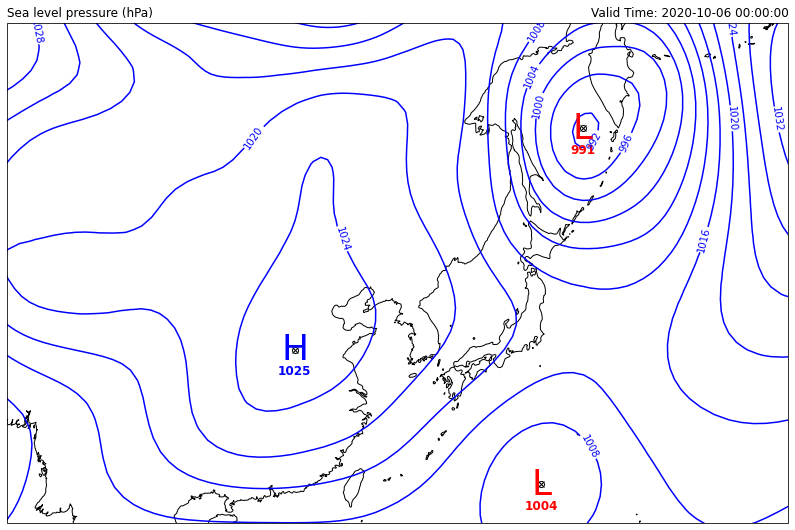

In [19]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.EquidistantConic(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([90, 160, 20, 60], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot surface pressure in hPa
clevs_pres = np.arange(860, 1100, 4)
cs = ax.contour(lons, lats, pres.to('hPa'), clevs_pres, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Use definition to plot H/L symbols
plot_maxmin_points(lons, lats, pres.m, 'max', 50,
                   symbol='H', color='blue', transform=ccrs.PlateCarree())
plot_maxmin_points(lons, lats, pres.m, 'min', 25,
                   symbol='L', color='red', transform=ccrs.PlateCarree())

# Make some nice titles for the plot (one right, one left)
plt.title('Sea level pressure (hPa)',
           loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

In [18]:
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color.

    Parameters
    ----------
        lon : 2D array
            Plotting longitude values
        lat : 2D array
            Plotting latitude values
        data : 2D array
            Data that you wish to plot the max/min symbol placement
        extrema : str
            Either a value of max for Maximum Values or min for Minimum Values
        nsize : int
            Size of the grid box to filter the max and min values to plot a reasonable number
        symbol : str
            Text to be placed at location of max/min value
        color : str
            Name of matplotlib colorname to plot the symbol (and numerical value, if plotted)
        plot_value : Boolean (True/False)
            Whether to plot the numeric value of max/min point

    Return
    ------
        The max/min symbol will be plotted on the current axes within the bounding frame
        (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    if lon.ndim == 1:
        lon, lat = np.meshgrid(lon, lat)

    mxx, mxy = np.where(data_ext == data)

    for i in range(len(mxy)):
        ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], symbol, color=color, size=36,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                '\n' + str(np.int(data[mxx[i], mxy[i]])),
                color=color, size=12, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
        ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], marker='o', markeredgecolor='black',
                markerfacecolor='white', transform=transform)
        ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                marker='x', color='black', transform=transform)